In [55]:
import random
import gym
from gym import error, spaces
import pandas as pd
import numpy as np
from enum import Enum
from stockstats import StockDataFrame
# from tensorboardX import SummaryWriter

import gym
import datetime as dt
import matplotlib.pyplot as plt

from stable_baselines.common.policies import MlpPolicy, CnnPolicy, MlpLstmPolicy, ActorCriticPolicy, LstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines import PPO2, PPO1, A2C, DQN, TD3, SAC

# from stable_baselines3.common.policies import MlpPolicy
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3.common.evaluation import evaluate_policy

from sklearn import preprocessing

import datetime
import backtrader as bt
import backtrader.indicators as bi
from backtrader.feeds import PandasData

# import backtest
import pandas as pd
import numpy as np
# import math
import matplotlib.pyplot as plt

from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo, Blackly

Loading BokehJS ...

In [3]:
from lutils.stock import LTdxHq

In [4]:
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_NUM_AMOUNTS = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 60
MAX_STEPS = 240 # 40000
NEXT_OBSERVATION_SIZE = 10

INITIAL_ACCOUNT_BALANCE = 10000

# writer = SummaryWriter('log')

In [34]:
ltdxhq = LTdxHq()
code = '603636' # 603828 603828 000032 300142 603636 600519
# df = ltdxhq.get_k_data_1min(code, end='2021-09-02') # 000032 300142 603636 600519
df = ltdxhq.get_k_data_daily(code, end='2021-01-01') # 000032 300142 603636 600519
df = StockDataFrame(df.rename(columns={'vol': 'volume'}))
# df['macd']
# df['kdjk']
# df['rsi_6']
# df['rsi_12']

# df_eval = ltdxhq.get_k_data_1min(code, start='2021-08-10')
df_eval = ltdxhq.get_k_data_daily(code, start='2021-01-01')
df_eval = StockDataFrame(df_eval.rename(columns={'vol': 'volume'}))

ltdxhq.close()

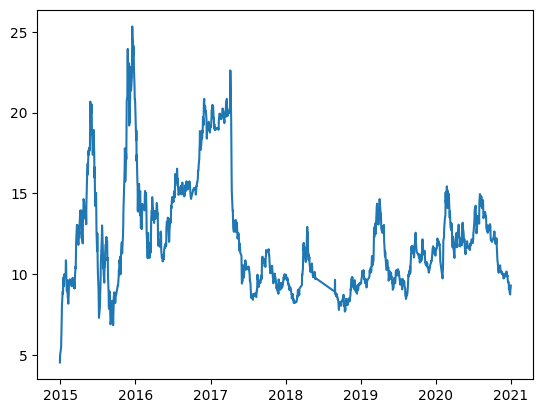

In [35]:
plt.plot(df.close)
plt.show()

In [36]:
df.max().open

25.16

In [45]:
class LStockDailyEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(LStockDailyEnv, self).__init__()

        self.df = df
        self.max = df.max()

        self.current_step = NEXT_OBSERVATION_SIZE

#         self.reward_range = (-np.inf, np.inf)
        self.reward_range = (-1, 1)

        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)

        self.observation_space = spaces.Box(low=-1, high=1, shape=(6, NEXT_OBSERVATION_SIZE + 1), dtype=np.float16)
        
        self.min_max_scaler = preprocessing.MinMaxScaler()

    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between 0-1
        frame = np.array([
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['open'].values / MAX_SHARE_PRICE,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['high'].values / MAX_SHARE_PRICE,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['low'].values / MAX_SHARE_PRICE,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['close'].values / MAX_SHARE_PRICE,
            # self.df.iloc[self.current_step: self.current_step + NEXT_OBSERVATION_SIZE]['vol'].values / MAX_NUM_SHARES,

            # self.df['macd'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # self.df['macdh'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # self.df['macds'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['volume_delta'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['open_2_d'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['open_-2_r'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['cr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['cr-ma1'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # # self.df['cr-ma2'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # # self.df['cr-ma3'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # self.df['kdjk'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # self.df['kdjd'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # self.df['kdjj'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # self.df['open_2_sma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['dma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['pdi'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['mdi'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['dx'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['adx'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # self.df['adxr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # # self.df['tema'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,
            # # # self.df['vr'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].fillna(0).values,
            # # # self.df['vr_6_sma'][self.current_step: self.current_step + NEXT_OBSERVATION_SIZE].values,

#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['open'].values / MAX_SHARE_PRICE,
#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['high'].values / MAX_SHARE_PRICE,
#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['low'].values / MAX_SHARE_PRICE,
#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['close'].values / MAX_SHARE_PRICE,
#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['volume'].values / MAX_NUM_SHARES,
#             self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['amount'].values / MAX_NUM_SHARES,

#             self.df['macd'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['macdh'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['macds'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['kdjk'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['kdjd'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['kdjj'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,

#             self.df['rsi_6'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
#             self.df['rsi_12'][self.current_step - NEXT_OBSERVATION_SIZE: self.current_step].fillna(0).values,
            
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['open'].values / self.max.open,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['high'].values / self.max.high,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['low'].values / self.max.low,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['close'].values / self.max.close,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['volume'].values / self.max.volume,
            self.df.iloc[self.current_step - NEXT_OBSERVATION_SIZE: self.current_step]['amount'].values / self.max.amount,

        ])
        
        bal = np.ones([6, 1]) * self.balance / self.net_worth
        
        frame = np.hstack([frame, bal])
        
#         print(frame)
#         print('##########')
#         frame = self.min_max_scaler.fit_transform(frame)
# #         frame = pd.DataFrame(min_max_scaler.fit_transform(df), index=df.index, columns=df.columns)
# #         frame = self.scaler.fit_transform(frame)
#         print(frame)
#         print('*****************')
        
        return frame

    def _take_action(self, action):
        current_price = self.df.iloc[self.current_step]['close'] # + 0.02
        action_type = action[0]
        amount = action[1]
        
        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0
        
        
    def step(self, action):
        # Execute one time step within the environment
        shares_held = self.shares_held
        self._take_action(action)

        # self.net_worth <= INITIAL_ACCOUNT_BALANCE * .9 or
        done =  (self.current_step + 1) >= self.df.shape[0] # or self.df.index[self.current_step].weekday() == 4

        obs = self._next_observation()
        reward = 0
        action_type = action[0]
        
        if not done:
#             if action_type < 1: # Buy
#                 reward = self.df.iloc[self.current_step + 1]['close'] - self.df.iloc[self.current_step]['close']
#             elif action_type >= 1 and action_type < 2: # Sell
#                 reward = self.df.iloc[self.current_step]['close'] - self.df.iloc[self.current_step + 1]['close']
#             else: # Hold
#                 reward = self.net_worth - self.old_net_worth # self.df.iloc[self.current_step + 1]['close'] - self.df.iloc[self.current_step]['close']
            
            reward = self.df.iloc[self.current_step + 1]['close'] - self.df.iloc[self.current_step]['close']
            if (self.shares_held <= 0 and reward > 0) or (self.shares_held > 0 and reward < 0):
                reward = -reward
            
            if action_type < 2 and self.old_balance == self.balance:
                reward = reward * .5
            elif action_type >= 2 and self.shares_held <= 0:
                reward = -1
            
            self.old_balance = self.balance
        else:
            reward = (self.net_worth - INITIAL_ACCOUNT_BALANCE) / INITIAL_ACCOUNT_BALANCE
#             print(self.balance, reward)
        
        self.old_net_worth = self.net_worth
        self.current_step = self.current_step + 1
        
        return obs, reward, done, {'net_worth': self.net_worth}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.old_balance = self.balance
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.old_net_worth = self.net_worth
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        if self.current_step + 5 >= self.df.shape[0]:
            self.current_step = NEXT_OBSERVATION_SIZE
        # else:
            # self.current_step = self.current_step + 1

        return self._next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [46]:
env = DummyVecEnv([lambda: LStockDailyEnv(df)])
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[256, 256], pi=[256, 256])])

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=100000)
# model.save('ppo_stock')

d:\soft\python\python37\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------
| explained_variance | 0.0375   |
| fps                | 19       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 0.663    |
---------------------------------


d:\soft\python\python37\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in double_scalars


---------------------------------
| explained_variance | 0.0542   |
| fps                | 395      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 0.00387  |
---------------------------------
---------------------------------
| explained_variance | 0.00921  |
| fps                | 432      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 0.137    |
---------------------------------
---------------------------------
| explained_variance | 0.057    |
| fps                | 437      |
| nupdates           | 300      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1500     |
| value_loss         | 3.06     |
---------------------------------
---------------------------------
| explained_variance | -0.0455  |
| fps                | 444      |
| nupdates           | 400      |
| policy_entropy     | 2.82     |
| total_timest

---------------------------------
| explained_variance | -4.95    |
| fps                | 482      |
| nupdates           | 3200     |
| policy_entropy     | 3.17     |
| total_timesteps    | 16000    |
| value_loss         | 0.07     |
---------------------------------
---------------------------------
| explained_variance | -0.383   |
| fps                | 483      |
| nupdates           | 3300     |
| policy_entropy     | 3.18     |
| total_timesteps    | 16500    |
| value_loss         | 0.0648   |
---------------------------------
---------------------------------
| explained_variance | -0.517   |
| fps                | 483      |
| nupdates           | 3400     |
| policy_entropy     | 3.2      |
| total_timesteps    | 17000    |
| value_loss         | 0.0413   |
---------------------------------
---------------------------------
| explained_variance | -0.922   |
| fps                | 483      |
| nupdates           | 3500     |
| policy_entropy     | 3.2      |
| total_timest

---------------------------------
| explained_variance | -1.69    |
| fps                | 483      |
| nupdates           | 6300     |
| policy_entropy     | 3.43     |
| total_timesteps    | 31500    |
| value_loss         | 0.0311   |
---------------------------------
---------------------------------
| explained_variance | -0.321   |
| fps                | 483      |
| nupdates           | 6400     |
| policy_entropy     | 3.44     |
| total_timesteps    | 32000    |
| value_loss         | 0.0768   |
---------------------------------
---------------------------------
| explained_variance | -2.76    |
| fps                | 483      |
| nupdates           | 6500     |
| policy_entropy     | 3.44     |
| total_timesteps    | 32500    |
| value_loss         | 0.148    |
---------------------------------
---------------------------------
| explained_variance | -4.46    |
| fps                | 484      |
| nupdates           | 6600     |
| policy_entropy     | 3.44     |
| total_timest

---------------------------------
| explained_variance | -3.15    |
| fps                | 485      |
| nupdates           | 9400     |
| policy_entropy     | 3.61     |
| total_timesteps    | 47000    |
| value_loss         | 4.88     |
---------------------------------
---------------------------------
| explained_variance | -0.0315  |
| fps                | 485      |
| nupdates           | 9500     |
| policy_entropy     | 3.61     |
| total_timesteps    | 47500    |
| value_loss         | 0.398    |
---------------------------------
---------------------------------
| explained_variance | -7.69    |
| fps                | 485      |
| nupdates           | 9600     |
| policy_entropy     | 3.63     |
| total_timesteps    | 48000    |
| value_loss         | 0.794    |
---------------------------------
---------------------------------
| explained_variance | -0.751   |
| fps                | 485      |
| nupdates           | 9700     |
| policy_entropy     | 3.64     |
| total_timest

---------------------------------
| explained_variance | 0.559    |
| fps                | 486      |
| nupdates           | 12500    |
| policy_entropy     | 3.92     |
| total_timesteps    | 62500    |
| value_loss         | 0.0942   |
---------------------------------
---------------------------------
| explained_variance | -6.59    |
| fps                | 486      |
| nupdates           | 12600    |
| policy_entropy     | 3.93     |
| total_timesteps    | 63000    |
| value_loss         | 0.146    |
---------------------------------
---------------------------------
| explained_variance | -2.46    |
| fps                | 486      |
| nupdates           | 12700    |
| policy_entropy     | 3.93     |
| total_timesteps    | 63500    |
| value_loss         | 0.22     |
---------------------------------
---------------------------------
| explained_variance | -381     |
| fps                | 486      |
| nupdates           | 12800    |
| policy_entropy     | 3.94     |
| total_timest

---------------------------------
| explained_variance | -1.2     |
| fps                | 486      |
| nupdates           | 15600    |
| policy_entropy     | 4.16     |
| total_timesteps    | 78000    |
| value_loss         | 0.0154   |
---------------------------------
---------------------------------
| explained_variance | 0.427    |
| fps                | 486      |
| nupdates           | 15700    |
| policy_entropy     | 4.17     |
| total_timesteps    | 78500    |
| value_loss         | 0.798    |
---------------------------------
---------------------------------
| explained_variance | 0.268    |
| fps                | 486      |
| nupdates           | 15800    |
| policy_entropy     | 4.18     |
| total_timesteps    | 79000    |
| value_loss         | 0.314    |
---------------------------------
---------------------------------
| explained_variance | 0.292    |
| fps                | 486      |
| nupdates           | 15900    |
| policy_entropy     | 4.19     |
| total_timest

---------------------------------
| explained_variance | 0.362    |
| fps                | 486      |
| nupdates           | 18700    |
| policy_entropy     | 4.37     |
| total_timesteps    | 93500    |
| value_loss         | 0.0354   |
---------------------------------
---------------------------------
| explained_variance | -0.0325  |
| fps                | 486      |
| nupdates           | 18800    |
| policy_entropy     | 4.39     |
| total_timesteps    | 94000    |
| value_loss         | 0.697    |
---------------------------------
---------------------------------
| explained_variance | -1.31    |
| fps                | 486      |
| nupdates           | 18900    |
| policy_entropy     | 4.4      |
| total_timesteps    | 94500    |
| value_loss         | 0.552    |
---------------------------------
---------------------------------
| explained_variance | -2.01    |
| fps                | 486      |
| nupdates           | 19000    |
| policy_entropy     | 4.41     |
| total_timest

d:\soft\python\python37\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Step: 11
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 12
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 13
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 14
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 15
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 16
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 17
Balance: 10000
Shares held: 0 (

Step: 145
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 146
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 147
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 148
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 149
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 150
Balance: 10000
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0)
Net worth: 10000.0 (Max net worth: 10000)
Profit: 0.0
Step: 151
Balance: 10000
Shares he

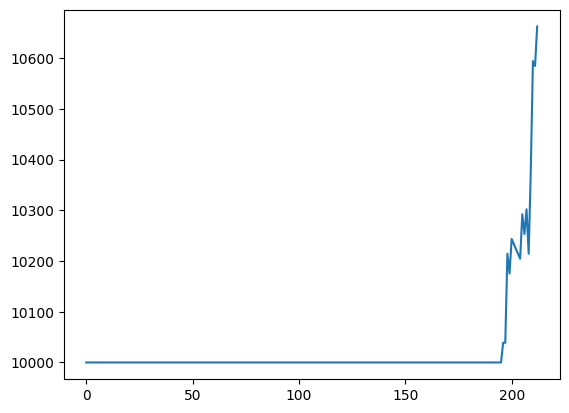

In [50]:
eval_env = DummyVecEnv([lambda: LStockDailyEnv(df_eval)])
obs = eval_env.reset()

net_worths = []
actions = [3] * NEXT_OBSERVATION_SIZE
done, state = False, None
# while not done:


for _ in range(NEXT_OBSERVATION_SIZE, df_eval.shape[0]):
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _info = eval_env.step(action)
    net_worths.append(_info[0]['net_worth'])
    
    actions.append(action[0][0])
    eval_env.render()
    
dff = df_eval.assign(action=actions)
    
plt.plot(net_worths)
plt.show()

In [51]:
actions

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,


In [52]:
dff

,open,close,high,low,volume,amount,action
date,,,,,,,
2021-01-04,9.18,9.29,9.30,9.09,4484555.0,41926596.0,3.0
2021-01-05,9.31,9.32,9.44,9.28,3896723.0,36895040.0,3.0
2021-01-06,9.26,9.16,9.30,9.11,3874385.0,36067080.0,3.0
2021-01-07,9.15,8.84,9.15,8.69,5851525.0,52623452.0,3.0
2021-01-08,8.80,8.91,9.12,8.65,4604155.0,41699760.0,3.0
...,...,...,...,...,...,...,...
2021-11-29,8.47,8.45,8.51,8.40,2552180.0,21586008.0,3.0
2021-11-30,8.47,8.62,8.68,8.47,4761001.0,40916040.0,3.0
2021-12-01,8.59,8.84,8.88,8.58,5064556.0,44612984.0,3.0


In [56]:
class PandasDataDd(PandasData):
    # Add a 'action' line to the inherited ones from the base class
    lines = ('action',)
    
    # add the parameter to the parameters inherited from the base class
    params = (('action', 7),)

In [73]:
class RLCross(bt.Strategy):
    def __init__(self):
#         self.sma1 = bt.indicators.SMA(self.dnames.d.dd, period=10, plot=False)
#         self.sma2 = bt.indicators.SMA(self.dnames.d.dd, period=20, plot=False)
        
#         self.crossover = bt.indicators.CrossOver(self.sma1, self.sma2)
        pass

    def next(self):
        
        if not self.position:  # not in the market
            if self.data0.action < 1: # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.data0.action < 2 :  # in the market & cross to the downside
            self.close()

In [74]:
cerebro = bt.Cerebro(oldtrades=True)

feed = PandasDataDd(dataname=dff, action=6)

cerebro.adddata(feed, name='d')
cerebro.addstrategy(RLCross)

cerebro.broker.setcash(10000.0)

cerebro.broker.setcommission(0.0005)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

result = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10000.73


<IPython.core.display.Javascript object>


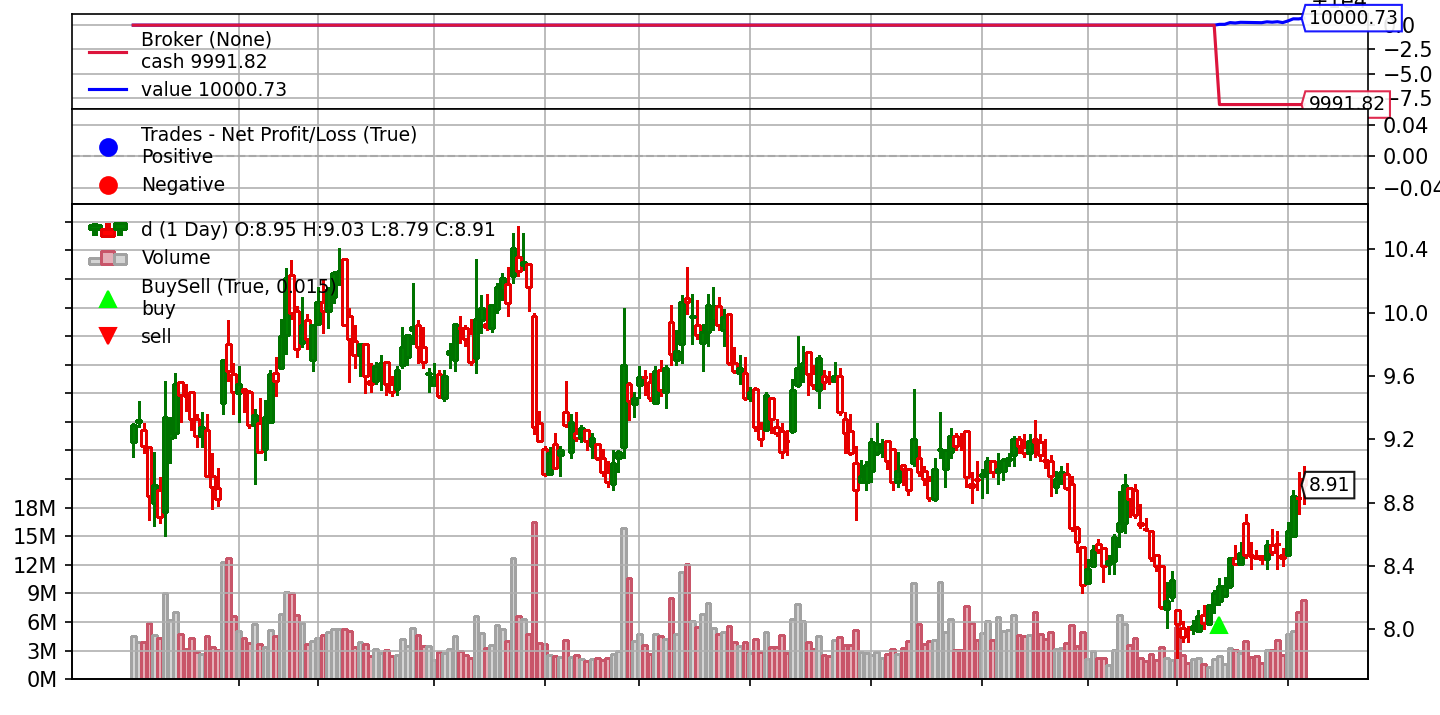

[[<Figure size 640x480 with 4 Axes>]]

In [67]:
cerebro.plot(
#     iplot=True,
#     start=datetime.date(2021, 1, 1),
#     end=datetime.date(2021, 11, 24),
    style='candlestick',
    barup='green',
    bardown='red',
    barupfill=True, 
    bardownfill=False,
)